# Rede Neural Perceptron Multicamadas - Skin Segmentation- Exercício de fixação 2

### Bibliotecas

In [53]:
import numpy as np
import pandas as pd
import random
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
from imblearn.under_sampling import NearMiss
#suppress warnings
warnings.filterwarnings('ignore')

### Primeiras impressões do conjunto de dados

##### Carregamento e informações

In [54]:
#Lendo o conjunto de dados
df = pd.read_csv('dataset/skin_noskin.csv')

#visualizando aleatoriamente 5 registros do conjunto de dados
df.sample(5).sort_index()

B    G    R  Class
9479    105  111  164      1
33569   177  191  244      1
56826   173  170  125      2
64225   215  227  233      2
224619   37   39  163      2

In [55]:
#Informações do conjunto de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245057 entries, 0 to 245056
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   B       245057 non-null  int64
 1   G       245057 non-null  int64
 2   R       245057 non-null  int64
 3   Class   245057 non-null  int64
dtypes: int64(4)
memory usage: 7.5 MB


In [56]:
#informações das variáveis
df.describe(include='all').loc[['count','min','max']]

B         G         R     Class
count  245057.0  245057.0  245057.0  245057.0
min         0.0       0.0       0.0       1.0
max       255.0     255.0     255.0       2.0

In [57]:
#Verificando a existência de valores ausentes (missing)
df.isnull().sum()

B        0
G        0
R        0
Class    0
dtype: int64

##### Heatmap

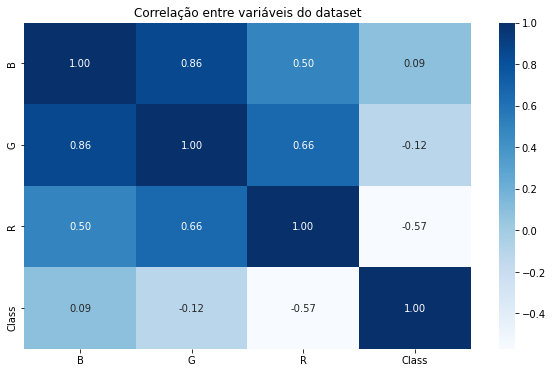

In [58]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(),
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis do dataset')
plt.show()

##### Boxplot

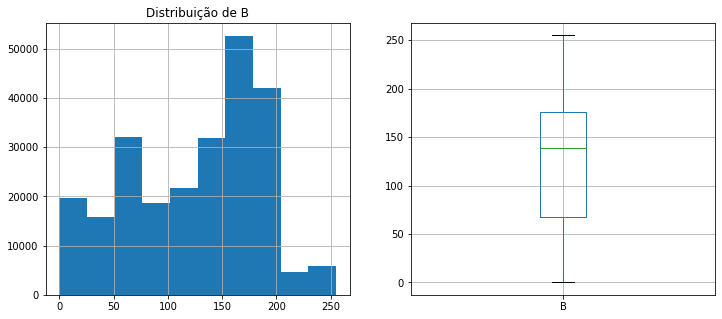

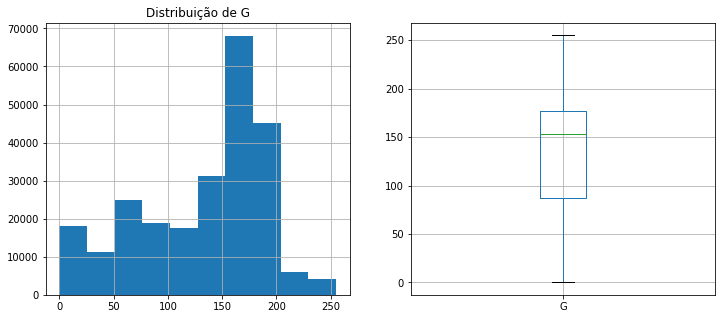

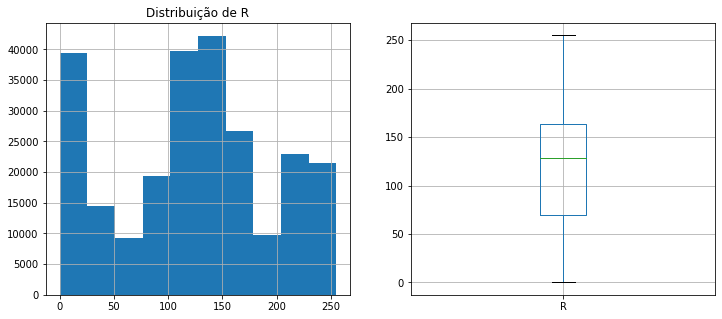

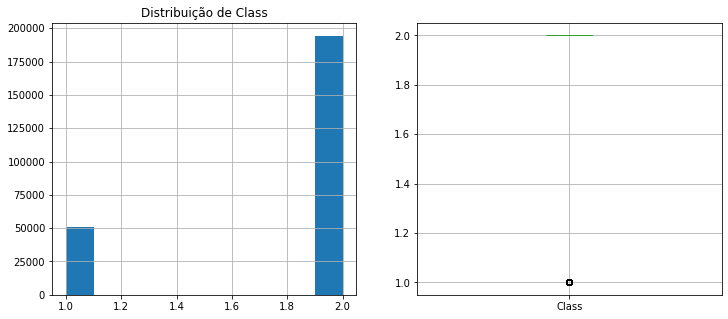

In [59]:
#Exibição do histograma da distribuição dos dados para identificar outliers
for col in df.columns:
    f, axes = plt.subplots(1,2, figsize = (12,5))
    df[col].hist(bins = 10, ax = axes[0])
    axes[0].set_title("Distribuição de "+ col)
    df.boxplot(column=col, ax = axes[1])
    plt.show()

### Pré processamento dos dados

#### Balanceamento

Text(0.5, 1.0, 'Distribuição de classes - não balanceado')

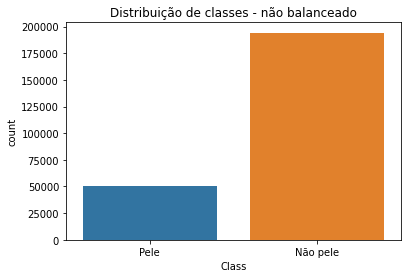

In [60]:
#Verificando o balanceamento da variável de decisão
df_cat = df.copy()
df_cat['Class'] = pd.cut(df_cat['Class'], 2, labels = ['Pele','Não pele'])
sns.countplot(x='Class', data=df_cat)
plt.title('Distribuição de classes - não balanceado')

Text(0.5, 1.0, 'Distribuição de classes - não balanceado - sem duplicatas')

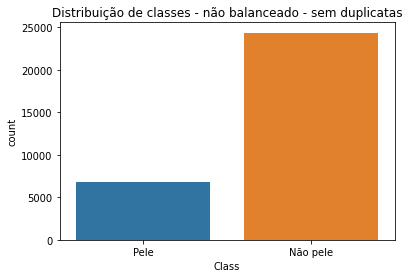

In [61]:
#Remoção de registros duplicados
df_unico = df.drop_duplicates(keep=False)
#remoção de registros duplicados mas com o mesmo em Class
df_unico = df_unico.drop_duplicates(subset=['B','G','R'], keep=False)

df_cat = df_unico.copy()
df_cat['Class'] = pd.cut(df_cat['Class'], 2, labels = ['Pele','Não pele'])
sns.countplot(x='Class', data=df_cat)
plt.title('Distribuição de classes - não balanceado - sem duplicatas')

Text(0.5, 1.0, 'Distribuição de classes - balanceado - sem duplicatas')

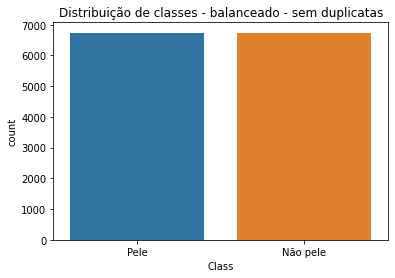

In [62]:
#Realizando o undersampling para reduzir o número de registros de Pele
X = df_unico.values[:, :-1]
y = df_unico.values[:, -1]
nr = NearMiss()
X, y = nr.fit_resample(X, y)

df_unico_norm = pd.DataFrame(X, columns=df_unico.columns[:-1])
df_unico_norm['Class'] = y

df_cat = df_unico_norm.copy()
df_cat['Class'] = pd.cut(df_cat['Class'], 2, labels = ['Pele','Não pele'])
sns.countplot(x='Class', data=df_cat)
plt.title('Distribuição de classes - balanceado - sem duplicatas')

In [63]:
#converter o df para float
df_unico_norm = df_unico_norm.astype(float)/1000
df_unico_norm['Class'] = df_unico_norm['Class'].astype(float)*1000
df_unico_norm['Class'] = pd.cut(df_unico_norm['Class'], 2, labels = [0, 1])
df_unico_norm.sample(5).sort_index()

B      G      R Class
7897   0.080  0.078  0.174     1
11162  0.180  0.140  0.175     1
12374  0.117  0.134  0.107     1
12420  0.153  0.116  0.248     1
12752  0.200  0.145  0.208     1

#### Remoção de outlier

#### Seleção de features promissoras

### Função de Ativação

In [64]:
def sigmoid(u):
    return 1.0 / (1.0 + np.exp(-u))

### Método de inicialização de pesos

In [65]:
def aleatorio_3C(n_entrada, n_oculta, n_saida):
    random.seed(30)
    w1 = np.zeros((n_entrada, n_oculta))
    w2 = np.zeros((n_oculta, n_saida))
    for i in range(0, n_entrada):
        for j in range(1, n_oculta):
            aleatorio = random.randint(1, 101)
            w1[i,j] = (1.0 - 2.0 * aleatorio) / 100.0
    for j in range(0, n_oculta):
        for k in range(0, n_saida):
            aleatorio = random.randint(1, 101)
            w2[j,k] = (1.0 - 2.0 * aleatorio) / 100.0
    return w1, w2

def aleatorio_4C(n_entrada, n_oculta1, n_oculta2, n_saida):
    random.seed(30)
    w1 = np.zeros((n_entrada, n_oculta1))
    w2 = np.zeros((n_oculta1, n_oculta2)) #Peso INT1->INT2
    w3 = np.zeros((n_oculta2, n_saida))
    for i in range(0, n_entrada):
        for j in range(1, n_oculta1):
            aleatorio = random.randint(1, 101)
            w1[i,j] = (1.0 - 2.0 * aleatorio) / 100.0
    for j in range(0, n_oculta1):
        for k in range(0, n_oculta2):
            aleatorio = random.randint(1, 101)
            w2[j,k] = (1.0 - 2.0*aleatorio)/100.0
    for j in range(0, n_oculta2):
        for k in range(0, n_saida):
            aleatorio = random.randint(1, 101)
            w3[j,k] = (1.0 - 2.0 * aleatorio) / 100.0
    return w1, w2, w3

### Classe Percetron Multicamada 3C

In [66]:
class MLP3C:
    def __init__(self, n_entrada, n_oculta, n_saida, inicializa_pesos, funcao_ativacao, nome_dt):
        self.n_entrada = n_entrada
        self.n_oculta = n_oculta
        self.n_saida = n_saida
        self.inicializa_pesos = inicializa_pesos
        self.w1 = self.w2 = np.array([])
        self.delta1 = self.delta2 = np.array([])
        self.funcao_ativacao = funcao_ativacao
        self.nome_dt = nome_dt
        self.erro_max = 0.0
        self.epocas = 0
        self.qtd_acertos = 0
        #self.bias = 1.0

    def intermediaria(self, x):
        h = np.zeros(self.n_oculta)
        h[0] = 1.0
        for j in range(1, self.n_oculta):
            somatorio = 0.0
            for i in range(0, self.n_entrada):
                somatorio = somatorio + x[i] * self.w1[i,j]
            h[j] = self.funcao_ativacao(somatorio)
        return h
    
    def saida(self, h):
        o = np.zeros(self.n_saida)
        for j in range(0, self.n_saida):
            somatorio = 0.0
            for i in range(0, self.n_oculta):
                somatorio = somatorio + h[i] * self.w2[i,j]
            o[j] = self.funcao_ativacao(somatorio)
        return o

    def erro_saida(self, o, y):
        somatorio = 0.0
        y = [y]
        for i in range(self.n_saida):
            somatorio = somatorio + (o[i] - y[i])*(o[i] - y[i])
        erro = 0.5 * somatorio
        return erro

    def erro2(self, o, y):
        y = [y]
        delta2 = np.zeros(self.n_saida)
        for i in range(self.n_saida):
            delta2[i] = o[i] * (1.0 - o[i]) * (y[i] - o[i])
        return delta2
   
    def erro1(self, h, delta2):
        delta1 = np.zeros(self.n_oculta)
        for i in range(1, self.n_oculta):
            somatorio = 0.0
            for j in range(0, self.n_saida):
                somatorio = somatorio + self.w2[i][j] * delta2[j]
            delta1[i] = h[i] * (1.0 - h[i]) * somatorio
        return delta1

    def ajusta2(self, h, eta):
        for i in range(self.n_oculta):
            for j in range(self.n_saida):
                self.w2[i][j] = self.w2[i][j] + eta * self.delta2[j] * h[i]
        
    def ajusta1(self, x, eta):
        for i in range(self.n_entrada):
            for j in range(1, self.n_oculta):
                self.w1[i][j] = self.w1[i][j] + eta * self.delta1[j] * x[i]

    def treinar(self, X, Y, eta, max_interacoes, erro_aceitavel, verbose=True):
        self.w1, self.w2 = self.inicializa_pesos(self.n_entrada, self.n_oculta, self.n_saida)
        erro_max = erro_aceitavel * 2.0
        erros = np.ones(len(X))
        i, m = 1, 0
        print(f'Treinando rede...')

        while erro_max > erro_aceitavel and i <= max_interacoes:
            if m == len(X): m = 0; erros = np.ones(len(X))
            x = X[m]
            y = Y[m]
            h = self.intermediaria(x)
            o = self.saida(h)
            erro_saida = self.erro_saida(o, y)
            self.delta2 = self.erro2(o, y)
            self.delta1 = self.erro1(h, self.delta2)
            self.ajusta2(h, eta)
            self.ajusta1(x, eta)
            #mostrar épocas do processo de treinamento
            if verbose:
                print(f'Época: {i} - Padrão>> {m+1} - Erro: {erro_saida:.9f}')
            
            #if erro_saida > erro_max: erro_max = erro_saida
            if erro_saida < erro_aceitavel:
                erros[m] = erro_saida
            if m == len(X)-1:
                erro_max = np.sum(erros)/len(X)
            i += 1
            m += 1
        
        self.erro_max = erro_max
        self.epocas = i - 1
        print(f'Épocas executadas: {i-1}')
        print(f'Menor erro durante o treino: {self.erro_max:.9f}')

    def testar(self, X, Y, verbose=False):
        Y_obtido = []
        erro_saida = []
        emq = 0.0
        for m in range(len(X)):
            x = X[m]
            y = Y[m]
            h = self.intermediaria(x)
            o = self.saida(h)
            erro_saida.append(self.erro_saida(o, y))
            o_9 = [f'{y:.9f}' for y in o]
            #if verbose:
            #    print(f'Padrão>> {m+1} - Calculado: {o_9[0]}, Desejado: {y}, Erro: {erro_saida[-1]:.9f}')
            Y_obtido.append(o)
            
        emq = np.sum(erro_saida) / len(X) # calcula a média dos erros quadrático médio
        qtd_acertos, acuracia = self.avaliar(Y_obtido, Y, erro_saida)
        self.qtd_acertos = qtd_acertos
        print(f'Erro Médio Quadrático do teste: {emq:.9f}')
        print(f'Classificações certas:  {qtd_acertos}')
        print(f'Classificações erradas: {len(X)-qtd_acertos}')
        print(f'Acurácia do teste: {acuracia:.2f}%')

        if verbose:
            df_w1 = pd.DataFrame(self.w1[:,1:], columns=['w1_h'+str(i) for i in range(1, self.n_oculta)], index=['entrada_'+str(i) for i in range(self.n_entrada)])
            #print(f'\nPesos Entrada/Oculta:')
            #display(df_w1)
            df_w2 = pd.DataFrame(self.w2, columns=['w2_o'+str(i) for i in range(self.n_saida)], index=['h_'+str(i) for i in range(self.n_oculta)])
            #print(f'Pesos Oculta/Saida:')
            #display(df_w2)
            Y_obtido_9 = [f'{y[0]:.9f}' for y in Y_obtido]
            with open('resultados/3C/resultado_' + self.nome_dt + '_3C.txt', 'w') as arquivo:
                arquivo.write(f'Cenário experimental com 3 camadas: {self.nome_dt}\n')
                for i in range(len(erro_saida)):
                    arquivo.write(f'\nPadrão>> {i+1} - Calculado: {Y_obtido_9[i]}, Desejado: {Y[i]}, Erro: {erro_saida[i]:.9f}')
                arquivo.write(f'\n\nErro Médio Quadrático: {emq:.9f}')
                arquivo.write(f'\n\nAcurácia: {acuracia:.2f}%')
                arquivo.write(f'\n\nPesos Entrada/Oculta:\n\n')
                arquivo.write(df_w1.to_string())
                arquivo.write(f'\n\nPesos Oculta/Saida:\n\n')
                arquivo.write(df_w2.to_string())
        return emq, acuracia

    # Acurácia por aproximação
    def avaliar(self, Y_obtido, Y, erros):
        qtd_acertos = erro_total = 0
        for i in range(len(Y_obtido)):
            if Y[i] == 0.0 and Y_obtido[i] >= 0.0 and Y_obtido[i] < 0.5:
                qtd_acertos += 1
                #erro_total += erros[i]
            elif Y[i] == 1.0 and Y_obtido[i] >= 0.5 and Y_obtido[i] <= 1.0:
                qtd_acertos += 1
                #erro_total += erros[i]
        acuracia = (qtd_acertos / len(Y_obtido)) * 100
        return qtd_acertos, acuracia

### Classe Percetron Multicamada 4C

In [67]:
class MLP4C:
    def __init__(self, n_entrada, n_oculta, n_saida, inicializa_pesos, funcao_ativacao, nome_dt):
        self.n_entrada = n_entrada
        self.n_oculta1 = n_oculta[0]
        self.n_oculta2 = n_oculta[1]
        self.n_saida = n_saida
        self.inicializa_pesos = inicializa_pesos
        self.w1 = self.w2 = self.w3 = np.array([])
        self.delta1 = self.delta2 = self.delta3 = np.array([])
        self.funcao_ativacao = funcao_ativacao
        self.nome_dt = nome_dt
        self.erro_max = 0.0
        self.epocas = 0
        self.qtd_acertos = 0
        #self.bias = 0.1
    
    def intermediaria1(self, x):
        h1 = np.zeros(self.n_oculta1)
        h1[0] = 1.0
        for j in range(1, self.n_oculta1):
            somatorio = 0.0
            for i in range(0, self.n_entrada):
                somatorio = somatorio + x[i] * self.w1[i,j]
            h1[j] = self.funcao_ativacao(somatorio)
        return h1

    def intermediaria2(self, h1):
        h2 = np.zeros(self.n_oculta2)
        h2[0] = 1.0
        for j in range(1, self.n_oculta2):
            somatorio = 0.0
            for i in range(0, self.n_oculta1):
                somatorio = somatorio + h1[i] * self.w2[i,j]
            h2[j] = self.funcao_ativacao(somatorio)
        return h2

    def saida(self, h2):
        o = np.zeros(self.n_saida)
        for j in range(0, self.n_saida):
            somatorio = 0.0
            for i in range(0, self.n_oculta2):
                somatorio = somatorio + h2[i] * self.w3[i,j]
            somatorio = -somatorio
            o[j] = 1.0 / (1.0 + np.exp(somatorio))
        return o

    def erro_saida(self, o, y):
        somatorio = 0.0
        y = [y]
        for i in range(self.n_saida):
            somatorio = somatorio + (y[i] - o[i])*(y[i] - o[i])
        erro = 0.5 * somatorio
        return erro
        
    def erro3(self, o, y):
        y = [y]
        delta3 = np.zeros(self.n_saida)
        for i in range(self.n_saida):
            delta3[i] = o[i] * (1.0 - o[i]) * (y[i] - o[i])
        return delta3
   
    def erro2(self, h2, delta3):
        #delta2 = np.zeros(self.n_oculta2-1)
        delta2 = np.zeros(self.n_oculta2)
        for i in range(1, self.n_oculta2):
            somatorio = 0.0
            for j in range(0, self.n_saida):
                somatorio = somatorio + self.w3[i][j] * delta3[j]
            delta2[i] = h2[i] * (1.0 - h2[i]) * somatorio
        return delta2
    
    def erro1(self, h1, delta2):
        #delta1 = np.zeros(self.n_oculta1-1)
        delta1 = np.zeros(self.n_oculta1)
        for i in range(1, self.n_oculta1):
            somatorio = 0.0
            for j in range(1, self.n_oculta2):
                somatorio = somatorio + self.w2[i][j] * delta2[j]
            delta1[i] = h1[i] * (1.0 - h1[i]) * somatorio
        return delta1

    def ajusta3(self, h2, eta):
        for i in range(0, self.n_oculta2):
            for j in range(0, self.n_saida):
                self.w3[i][j] = self.w3[i][j] + eta * self.delta3[j] * h2[i]
    
    def ajusta2(self, h1, eta):
        for i in range(0, self.n_oculta1):
            for j in range(1, self.n_oculta2):
                self.w2[i][j] = self.w2[i][j] + eta * self.delta2[j] * h1[i]
        
    def ajusta1(self, x, eta):
        for i in range(0, self.n_entrada):
            for j in range(1, self.n_oculta1):
                self.w1[i][j] = self.w1[i][j] + eta * self.delta1[j] * x[i]
                
    def treinar(self, X, Y, eta, max_interacoes, erro_aceitavel, verbose=True):
        self.w1, self.w2, self.w3 = self.inicializa_pesos(self.n_entrada, self.n_oculta1, self.n_oculta2 , self.n_saida)
        erro_max = erro_aceitavel * 2
        erros = np.ones(len(X))
        i, m = 1, 0
        print(f'Treinando rede...')

        while erro_max > erro_aceitavel and i <= max_interacoes:
            if m == len(X): m = 0; erros = np.ones(len(X))
            x = X[m]
            y = Y[m]

            h1 = self.intermediaria1(x)
            h2 = self.intermediaria2(h1)
            o = self.saida(h2)
            erro_saida = self.erro_saida(o, y)
            self.delta3 = self.erro3(o, y)
            self.delta2 = self.erro2(h2, self.delta3)
            self.delta1 = self.erro1(h1, self.delta2)
            self.ajusta3(h2, eta[2])
            self.ajusta2(h1, eta[1])
            self.ajusta1(x, eta[0])
            
            if verbose:
                print(f'Época: {i} - Padrão>> {m+1} - Erro: {erro_saida:.9f}')
            
            if erro_saida < erro_aceitavel:
                erros[m] = erro_saida
            if m == len(X)-1:
                erro_max = np.sum(erros)/len(X)
            i += 1
            m += 1

        self.erro_max = erro_max
        self.epocas = i - 1
        print(f'Épocas executadas: {i-1}')
        print(f'Menor erro durante o treino: {self.erro_max:.9f}')

    def testar(self, X, Y, verbose=False):
        Y_obtido = []
        erro_saida = []
        emq = 0.0
        for m in range(len(X)):
            x = X[m]
            y = Y[m]
            h1 = self.intermediaria1(x)
            h2 = self.intermediaria2(h1)
            o = self.saida(h2)
            erro_saida.append(self.erro_saida(o, y))
            o_9 = [f'{y:.9f}' for y in o]
            #if verbose:
            #    print(f'Padrão>> {m+1} - Calculado: {o_9[0]}, Desejado: {y}, Erro: {erro_saida[-1]:.9f}')
            Y_obtido.append(o)
        
        emq = np.sum(erro_saida) / len(X) # calcula o erro quadrático médio
        qtd_acertos, acuracia = self.avaliar(Y_obtido, Y, erro_saida)
        self.qtd_acertos = qtd_acertos
        print(f'Erro Médio Quadrático do teste: {emq:.9f}')
        print(f'Classificações certas:  {qtd_acertos}')
        print(f'Classificações erradas: {len(X)-qtd_acertos}')
        print(f'Acurácia do teste: {acuracia:.2f}%')

        if verbose:
            df_w1 = pd.DataFrame(self.w1[:,1:], columns=['w1_h'+str(i) for i in range(1, self.n_oculta1)], index=['entrada_'+str(i) for i in range(self.n_entrada)])
            #print(f'\nPesos Entrada/Oculta1:')
            #display(df_w1)
            df_w2 = pd.DataFrame(self.w2[:,1:], columns=['w2_h'+str(i) for i in range(1, self.n_oculta2)], index=['oculta1_'+str(i) for i in range(self.n_oculta1)])
            #print(f'\nPesos Oculta1/Oculta2:')
            #display(df_w2)
            df_w3 = pd.DataFrame(self.w3, columns=['w3_o'+str(i) for i in range(self.n_saida)], index=['oculta2_'+str(i) for i in range(self.n_oculta2)])
            #print(f'Pesos Oculta2/Saida:')
            #display(df_w3)
            Y_obtido_9 = [f'{y[0]:.9f}'  for y in Y_obtido]
            with open('resultados/4C/resultado_' + self.nome_dt + '_4C.txt', 'w') as arquivo:
                arquivo.write(f'Cenário experimental com 4 camadas: {self.nome_dt}\n')
                for i in range(len(erro_saida)):
                    arquivo.write(f'\nPadrão>> {i+1} - Calculado: {Y_obtido_9[i]}, Desejado: {Y[i]}, Erro: {erro_saida[i]:.9f}')
                arquivo.write(f'\n\nErro Médio Quadrático: {emq:.9f}')
                arquivo.write(f'\n\nAcurácia: {acuracia:.2f}%')
                arquivo.write(f'\n\nPesos Entrada/Oculta1:\n\n')
                arquivo.write(df_w1.to_string())
                arquivo.write(f'\n\nPesos Oculta1/Oculta2:\n\n')
                arquivo.write(df_w2.to_string())
                arquivo.write(f'\n\nPesos Oculta/Saida:\n\n')
                arquivo.write(df_w3.to_string())
        return emq, acuracia

    # Acurácia por aproximação
    def avaliar(self, Y_obtido, Y, erros):
        qtd_acertos = erro_total = 0
        for i in range(len(Y_obtido)):
            if Y[i] == 0.0 and Y_obtido[i] >= 0.0 and Y_obtido[i] < 0.5:
                qtd_acertos += 1
                #erro_total += erros[i]
            elif Y[i] == 1.0 and Y_obtido[i] >= 0.5 and Y_obtido[i] <= 1.0:
                qtd_acertos += 1
                #erro_total += erros[i]
        acuracia = (qtd_acertos / len(Y_obtido)) * 100
        return qtd_acertos, acuracia

### Métodos de divisão do dataset

In [68]:
def hold_out_split(df, train_size):
    dataset = df.values
    train, test = train_test_split(dataset, train_size=train_size)
    bias = 1.0
    x_train = np.insert(train[:, :-1], 0, bias, axis=1)
    y_train = train[:, -1]
    x_test = np.insert(test[:, :-1], 0, bias, axis=1)
    y_test = test[:, -1]
    return x_train, y_train, x_test, y_test

#função para dividir o dataset em k partes
def k_fold_split(df, k):
    np.random.seed(30)
    indices = np.random.permutation(len(df))
    size = len(indices)
    subset_size = round(size / k)
    subsets = [indices[x:x+subset_size] for x in range(0, len(indices), subset_size)]
    kfolds = []
    for i in range(k):
        test = subsets[i]
        train = []
        for subset in subsets:
            if set(subset) != set(test):
                train.append(subset)
        kfolds.append((train,test))
    dataset = df.values
    for fold in kfolds:
        for treino in fold[0]:
            indices_treino = treino
            indices_teste = fold[1]
            x_treino = np.insert(dataset[indices_treino, :-1], 0, 1.0, axis=1)
            y_treino = dataset[indices_treino, -1]
            x_teste = np.insert(dataset[indices_teste, :-1], 0, 1.0, axis=1)
            y_teste = dataset[indices_teste, -1]
            yield x_treino, y_treino, x_teste, y_teste
        
        '''#modo de execução com k-fold tradicional
        indices_treino = []
        for treino in fold[0]:
            for index in treino:
                indices_treino.append(index)
        indices_teste = fold[1]
        x_treino = np.insert(dataset[indices_treino, :-1], 0, 1.0, axis=1)
        y_treino = dataset[indices_treino, -1]
        x_teste = np.insert(dataset[indices_teste, :-1], 0, 1.0, axis=1)
        y_teste = dataset[indices_teste, -1]
        yield x_treino, y_treino, x_teste, y_teste'''

### Caso 01 - 3C HOLD OUT

In [69]:
n_entrada = len(df_unico_norm.columns)   # Número de entradas + bias
n_oculta = len(df_unico_norm.columns)    # Número de neurônios na camada oculta + bias
n_saida = 1                   # Número de neurônios na camada de saída
tx_aprend = 0.9
max_interacoes = 60000
erro_aceitavel = 0.0001
p_treino = 0.75

# Pegar 1000 registros aleatórios do df
#df_menor = df_unico_norm.sample(n=1000, random_state=30)

x_treino, y_treino, x_teste, y_teste = hold_out_split(df_unico_norm, p_treino)

print(f'Tamanho do conjunto>> Treino:{len(y_treino)} - Teste:{len(y_teste)}')

rede = MLP3C(n_entrada, n_oculta, n_saida, aleatorio_3C, sigmoid, 'Skin_Segmentation_HO')
rede.treinar(x_treino, y_treino, tx_aprend, max_interacoes, erro_aceitavel, verbose=True)
emq, acc = rede.testar(x_teste, y_teste, verbose=True)

Tamanho do conjunto>> Treino:10108 - Teste:3370
Treinando rede...
Época: 1 - Padrão>> 1 - Erro: 0.057896352
Época: 2 - Padrão>> 2 - Erro: 0.052872513
Época: 3 - Padrão>> 3 - Erro: 0.047652875
Época: 4 - Padrão>> 4 - Erro: 0.245264245
Época: 5 - Padrão>> 5 - Erro: 0.239509668
Época: 6 - Padrão>> 6 - Erro: 0.195779608
Época: 7 - Padrão>> 7 - Erro: 0.075093852
Época: 8 - Padrão>> 8 - Erro: 0.206238355
Época: 9 - Padrão>> 9 - Erro: 0.085076271
Época: 10 - Padrão>> 10 - Erro: 0.194253367
Época: 11 - Padrão>> 11 - Erro: 0.162925229
Época: 12 - Padrão>> 12 - Erro: 0.142044278
Época: 13 - Padrão>> 13 - Erro: 0.122172981
Época: 14 - Padrão>> 14 - Erro: 0.106117529
Época: 15 - Padrão>> 15 - Erro: 0.170758195
Época: 16 - Padrão>> 16 - Erro: 0.110801887
Época: 17 - Padrão>> 17 - Erro: 0.154367410
Época: 18 - Padrão>> 18 - Erro: 0.105520159
Época: 19 - Padrão>> 19 - Erro: 0.096503320
Época: 20 - Padrão>> 20 - Erro: 0.082381612
Época: 21 - Padrão>> 21 - Erro: 0.186693422
Época: 22 - Padrão>> 22 - Er

### Caso 02 - 3C K-FOLD CROSS VALIDATION

In [70]:
n_entrada = len(df_unico_norm.columns)   # Número de entradas + bias
n_oculta = len(df_unico_norm.columns)    # Número de neurônios na camada oculta + bias
n_saida = 1                   # Número de neurônios na camada de saída
tx_aprend = 0.9
max_interacoes = 60000
erro_aceitavel = 0.0001
k = 5

# Pegar 1000 registros aleatórios do df
#df_menor = df_unico_norm.sample(n=1000, random_state=30)

kfolds = k_fold_split(df_unico_norm, k)
emqs = [[] for i in range(k)]
accs = [[] for i in range(k)]
parti = []
for i in range(k):
    texto = []
    for j in range(k):
        if i != j:
            texto.append(f'D{j+1}-D{i+1}')
    parti.append(texto)       
i = j = 0
for x_treino, y_treino, x_teste, y_teste in kfolds:
    if j == k-1: j = 0; i += 1
    print(f'Cross-Validation>> {i+1} - Partições: {parti[i][j]}')
    print(f'Tamanho do conjunto>> Treino:{len(y_treino)} - Teste:{len(y_teste)}')
    rede = MLP3C(n_entrada, n_oculta, n_saida, aleatorio_3C, sigmoid, f'Skin_Segmentation_CV_{parti[i][j]}')
    rede.treinar(x_treino, y_treino, tx_aprend, max_interacoes, erro_aceitavel, verbose=False)
    emq, acc = rede.testar(x_teste, y_teste, verbose=True)
    emqs[i].append(emq)
    accs[i].append(acc)
    print(f'\n')
    j += 1
    if j == k-1:
        print(f'Erro Médio Quadrático Final: {np.mean(emqs[i]):.9f}')
        print(f'Acurácia Final: {np.mean(accs[i]):.2f}%\n')

Cross-Validation>> 1 - Partições: D2-D1
Tamanho do conjunto>> Treino:2696 - Teste:2696
Treinando rede...
Épocas executadas: 60000
Menor erro durante o treino: 0.907272473
Erro Médio Quadrático do teste: 0.068737217
Classificações certas:  2246
Classificações erradas: 450
Acurácia do teste: 83.31%


Cross-Validation>> 1 - Partições: D3-D1
Tamanho do conjunto>> Treino:2696 - Teste:2696
Treinando rede...
Épocas executadas: 60000
Menor erro durante o treino: 0.890952841
Erro Médio Quadrático do teste: 0.065999853
Classificações certas:  2277
Classificações erradas: 419
Acurácia do teste: 84.46%


Cross-Validation>> 1 - Partições: D4-D1
Tamanho do conjunto>> Treino:2696 - Teste:2696
Treinando rede...
Épocas executadas: 60000
Menor erro durante o treino: 0.920625750
Erro Médio Quadrático do teste: 0.065759049
Classificações certas:  2275
Classificações erradas: 421
Acurácia do teste: 84.38%


Cross-Validation>> 1 - Partições: D5-D1
Tamanho do conjunto>> Treino:2694 - Teste:2696
Treinando red

### Métodos Grid Search

In [71]:
def grid_hold_out(n_entrada, NINT1, n_saida, TAP1, df, P_TREINO, max_interacoes, erro_aceitavel, dt_nome):
    rede = []
    f = open('resultados/3C/grid_' + dt_nome + '_3C.csv', 'w', newline='', encoding='utf-8')
    arquivo = csv.writer(f)
    arquivo.writerow(['C1','C2','C3','Taxa_aprend','Hold-out','Épocas','Menor_erro','Acertos','Erros','EMQ','Acurácia'])
    for nint1 in NINT1:
        for tap1 in TAP1:
            for p_treino in P_TREINO:
                print(f'C2: {nint1} - Taxa: {tap1} - Hold-out: {(p_treino*100):.0f}%-{round((1-p_treino)*100):.0f}%')
                x_treino, y_treino, x_teste, y_teste = hold_out_split(df, p_treino)
                rede.append(MLP3C(n_entrada, nint1, n_saida, aleatorio_3C, sigmoid, dt_nome))
                rede[-1].treinar(x_treino, y_treino, tap1, max_interacoes, erro_aceitavel, verbose=False)
                emq, acc = rede[-1].testar(x_teste, y_teste, verbose=False)
                epocas = rede[-1].epocas
                erro_max = f'{rede[-1].erro_max:.9f}'
                qtd_acertos = rede[-1].qtd_acertos
                qtd_erros = len(x_teste) - qtd_acertos
                print(f'')         
                arquivo.writerow([n_entrada,nint1,n_saida,tap1,f'{(p_treino*100):.0f}%-{round((1-p_treino)*100):.0f}%',epocas,erro_max,qtd_acertos,qtd_erros,f'{emq:.9f}',f'{acc:.2f}%'])
    f.close()

def grid_cv(n_entrada, NINT1, n_saida, TAP1, df, K, max_interacoes, erro_aceitavel, dt_nome):
    rede = []
    f = open('resultados/3C/grid_' + dt_nome + '_3C.csv', 'w', newline='', encoding='utf-8')
    arquivo = csv.writer(f)
    arquivo.writerow(['C1','C2','C3','Taxa_aprend','k-Fold','EMQ','Acurácia'])
    for nint1 in NINT1:
        for tap1 in TAP1:
            for k in K:
                kfolds = k_fold_split(df, k)
                emqs = [[] for i in range(k)]
                accs = [[] for i in range(k)]
                parti = []
                for i in range(k):
                    texto = []
                    for j in range(k):
                        if i != j:
                            texto.append(f'D{j+1}-D{i+1}')
                    parti.append(texto) 
                i = j = 0
                for x_treino, y_treino, x_teste, y_teste in kfolds:
                    if j == k-1: j = 0; i += 1
                    print(f'Cross-Validation>> {i+1} - Partições: {parti[i][j]}')
                    print(f'Tamanho do conjunto>> Treino:{len(y_treino)} - Teste:{len(y_teste)}')
                    rede.append(MLP3C(n_entrada, nint1, n_saida, aleatorio_3C, sigmoid, dt_nome))
                    rede[-1].treinar(x_treino, y_treino, tap1, max_interacoes, erro_aceitavel, verbose=False)
                    emq, acc = rede[-1].testar(x_teste, y_teste, verbose=False)
                    emqs[i].append(emq)
                    accs[i].append(acc)
                    print(f'\n')
                    j += 1
                    if j == k-1:
                        emq_mean = f'{np.mean(emqs[i]):.9f}'
                        acc_mean = f'{np.mean(accs[i]):.2f}%'
                        print(f'Erro Médio Quadrático Final: {emq_mean}')
                        print(f'Acurácia Final: {acc_mean}\n')
                        arquivo.writerow([n_entrada,nint1,n_saida,tap1,f'{k}-Fold{i+1}',emq_mean,acc_mean])
                print(f'')         
    f.close()

### Grid do Caso 01

In [72]:
n_entrada = len(df_unico_norm.columns)
NINT1 = [len(df_unico_norm.columns), len(df_unico_norm.columns)+6]
n_saida = 1
TAP1 = [0.90, 0.65, 0.30]
p_treino = [0.6, 0.7, 0.8]
max_interacoes = 60000
erro_aceitavel = 0.0001

grid_hold_out(n_entrada, NINT1, n_saida, TAP1, df_unico_norm, p_treino, max_interacoes, erro_aceitavel, 'Skin_Segmentation_HO')

C2: 4 - Taxa: 0.9 - Hold-out: 60%-40%
Treinando rede...
Épocas executadas: 60000
Menor erro durante o treino: 0.906383961
Erro Médio Quadrático do teste: 0.069228019
Classificações certas:  4559
Classificações erradas: 833
Acurácia do teste: 84.55%

C2: 4 - Taxa: 0.9 - Hold-out: 70%-30%
Treinando rede...
Épocas executadas: 60000
Menor erro durante o treino: 0.916474701
Erro Médio Quadrático do teste: 0.065473808
Classificações certas:  3427
Classificações erradas: 617
Acurácia do teste: 84.74%

C2: 4 - Taxa: 0.9 - Hold-out: 80%-20%
Treinando rede...
Épocas executadas: 60000
Menor erro durante o treino: 0.917550256
Erro Médio Quadrático do teste: 0.068377035
Classificações certas:  2263
Classificações erradas: 433
Acurácia do teste: 83.94%

C2: 4 - Taxa: 0.65 - Hold-out: 60%-40%
Treinando rede...
Épocas executadas: 60000
Menor erro durante o treino: 0.937301475
Erro Médio Quadrático do teste: 0.072362157
Classificações certas:  4523
Classificações erradas: 869
Acurácia do teste: 83.88%


### Grid do Caso 02

In [73]:
n_entrada = len(df_unico_norm.columns)
NINT1 = [len(df_unico_norm.columns), len(df_unico_norm.columns)+6]
n_saida = 1
TAP1 = [0.90, 0.65, 0.30]
k = [5]
max_interacoes = 60000
erro_aceitavel = 0.0001

grid_cv(n_entrada, NINT1, n_saida, TAP1, df_unico_norm, k, max_interacoes, erro_aceitavel, 'Skin_Segmentation_CV')

Cross-Validation>> 1 - Partições: D2-D1
Tamanho do conjunto>> Treino:2696 - Teste:2696
Treinando rede...
Épocas executadas: 60000
Menor erro durante o treino: 0.907272473
Erro Médio Quadrático do teste: 0.068737217
Classificações certas:  2246
Classificações erradas: 450
Acurácia do teste: 83.31%


Cross-Validation>> 1 - Partições: D3-D1
Tamanho do conjunto>> Treino:2696 - Teste:2696
Treinando rede...
Épocas executadas: 60000
Menor erro durante o treino: 0.890952841
Erro Médio Quadrático do teste: 0.065999853
Classificações certas:  2277
Classificações erradas: 419
Acurácia do teste: 84.46%


Cross-Validation>> 1 - Partições: D4-D1
Tamanho do conjunto>> Treino:2696 - Teste:2696
Treinando rede...
Épocas executadas: 60000
Menor erro durante o treino: 0.920625750
Erro Médio Quadrático do teste: 0.065759049
Classificações certas:  2275
Classificações erradas: 421
Acurácia do teste: 84.38%


Cross-Validation>> 1 - Partições: D5-D1
Tamanho do conjunto>> Treino:2694 - Teste:2696
Treinando red

### Caso 03 - 4C HOLD OUT

In [74]:
n_entrada = len(df_unico_norm.columns)   # Número de entradas + bias
n_oculta = [len(df_unico_norm.columns), len(df_unico_norm.columns)+6]    # Número de neurônios na camada oculta + bias
n_saida = 1                   # Número de neurônios na camada de saída
tx_aprend = [0.90, 0.90, 0.90]
max_interacoes = 60000
erro_aceitavel = 0.0001
p_treino = 0.75

x_treino, y_treino, x_teste, y_teste = hold_out_split(df_unico_norm, p_treino)

print(f'Tamanho do conjunto>> Treino:{len(y_treino)} - Teste:{len(y_teste)}')

rede = MLP4C(n_entrada, n_oculta, n_saida, aleatorio_4C, sigmoid, 'Skin_Segmentation_HO')
rede.treinar(x_treino, y_treino, tx_aprend, max_interacoes, erro_aceitavel, verbose=True)
emq, acc = rede.testar(x_teste, y_teste, verbose=True)

Tamanho do conjunto>> Treino:10108 - Teste:3370
Treinando rede...
Época: 1 - Padrão>> 1 - Erro: 0.001688721
Época: 2 - Padrão>> 2 - Erro: 0.440203050
Época: 3 - Padrão>> 3 - Erro: 0.430170878
Época: 4 - Padrão>> 4 - Erro: 0.420649810
Época: 5 - Padrão>> 5 - Erro: 0.420041700
Época: 6 - Padrão>> 6 - Erro: 0.004758475
Época: 7 - Padrão>> 7 - Erro: 0.004312609
Época: 8 - Padrão>> 8 - Erro: 0.004900945
Época: 9 - Padrão>> 9 - Erro: 0.004275117
Época: 10 - Padrão>> 10 - Erro: 0.411749566
Época: 11 - Padrão>> 11 - Erro: 0.004390369
Época: 12 - Padrão>> 12 - Erro: 0.415598415
Época: 13 - Padrão>> 13 - Erro: 0.398713320
Época: 14 - Padrão>> 14 - Erro: 0.388809178
Época: 15 - Padrão>> 15 - Erro: 0.353773867
Época: 16 - Padrão>> 16 - Erro: 0.332858528
Época: 17 - Padrão>> 17 - Erro: 0.307544534
Época: 18 - Padrão>> 18 - Erro: 0.031253592
Época: 19 - Padrão>> 19 - Erro: 0.029225082
Época: 20 - Padrão>> 20 - Erro: 0.297577388
Época: 21 - Padrão>> 21 - Erro: 0.267551591
Época: 22 - Padrão>> 22 - Er

### Caso 04 - 4C K-FOLD CROSS VALIDATION

In [75]:
n_entrada = len(df_unico_norm.columns)   # Número de entradas + bias
n_oculta = [len(df_unico_norm.columns), len(df_unico_norm.columns)+6]    # Número de neurônios na camada oculta + bias
n_saida = 1                   # Número de neurônios na camada de saída
tx_aprend = [0.90, 0.90, 0.90]
max_interacoes = 60000
erro_aceitavel = 0.0001
k = 5

# Pegar 1000 registros aleatórios do df
#df_menor = df_unico_norm.sample(n=1000, random_state=30)

kfolds = k_fold_split(df_unico_norm, k)
emqs = [[] for i in range(k)]
accs = [[] for i in range(k)]
parti = []
for i in range(k):
    texto = []
    for j in range(k):
        if i != j:
            texto.append(f'D{j+1}-D{i+1}')
    parti.append(texto)       
i = j = 0
for x_treino, y_treino, x_teste, y_teste in kfolds:
    if j == k-1: j = 0; i += 1
    print(f'Cross-Validation>> {i+1} - Partições: {parti[i][j]}')
    print(f'Tamanho do conjunto>> Treino:{len(y_treino)} - Teste:{len(y_teste)}')
    rede = MLP4C(n_entrada, n_oculta, n_saida, aleatorio_4C, sigmoid, f'Skin_Segmentation_CV_{parti[i][j]}')
    rede.treinar(x_treino, y_treino, tx_aprend, max_interacoes, erro_aceitavel, verbose=False)
    emq, acc = rede.testar(x_teste, y_teste, verbose=True)
    emqs[i].append(emq)
    accs[i].append(acc)
    print(f'\n')
    j += 1
    if j == k-1:
        print(f'Erro Médio Quadrático Final: {np.mean(emqs[i]):.9f}')
        print(f'Acurácia Final: {np.mean(accs[i]):.2f}%\n')

Cross-Validation>> 1 - Partições: D2-D1
Tamanho do conjunto>> Treino:2696 - Teste:2696
Treinando rede...
Épocas executadas: 60000
Menor erro durante o treino: 0.969957526
Erro Médio Quadrático do teste: 0.047964872
Classificações certas:  2356
Classificações erradas: 340
Acurácia do teste: 87.39%


Cross-Validation>> 1 - Partições: D3-D1
Tamanho do conjunto>> Treino:2696 - Teste:2696
Treinando rede...
Épocas executadas: 60000
Menor erro durante o treino: 0.775599433
Erro Médio Quadrático do teste: 0.046471885
Classificações certas:  2362
Classificações erradas: 334
Acurácia do teste: 87.61%


Cross-Validation>> 1 - Partições: D4-D1
Tamanho do conjunto>> Treino:2696 - Teste:2696
Treinando rede...
Épocas executadas: 60000
Menor erro durante o treino: 0.892069406
Erro Médio Quadrático do teste: 0.049030224
Classificações certas:  2341
Classificações erradas: 355
Acurácia do teste: 86.83%


Cross-Validation>> 1 - Partições: D5-D1
Tamanho do conjunto>> Treino:2694 - Teste:2696
Treinando red